## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

In [2]:
df = pd.read_csv("ab_data.csv")
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
unique_user = df["user_id"].unique()
total = len(unique_user)
total

290584

d. The proportion of users converted.

In [5]:
df_converted = df[df["converted"] == 1]
df_converted["user_id"].count()/total


0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df_old_treatment = df[(df["group"] == "treatment")&(df["landing_page"] == "old_page")]
df_new_control = df[(df["group"] == "control")&(df["landing_page"] == "new_page")]

In [7]:
df_old_treatment["user_id"].count()+df_new_control["user_id"].count()

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
df2 = df[(df["group"] == "treatment")&(df["landing_page"] == "new_page")].append(df[(df["group"] == "control")&(df["landing_page"] == "old_page")])

In [10]:
df2.shape[0]

290585

In [11]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [13]:
len(df2["user_id"].unique())

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2_duplicated = df2[df2.duplicated(subset=['user_id'])]
df2_duplicated["user_id"]

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [15]:
df2_duplicated

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop_duplicates(subset='user_id', keep='last', inplace=True)

In [17]:
df2.shape

(290584, 5)

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
df_converted = df2[df2["converted"] ==1]
df_converted.shape[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df_control_converted = df2[(df2["group"] == "control")&(df2["converted"] == 1)]
df_control_converted.shape[0]/df2[(df2["group"] == "control")].shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df_control_converted = df2[(df2["group"] == "treatment")&(df2["converted"] == 1)]
df_control_converted.shape[0]/df2[(df2["group"] == "treatment")].shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [21]:
df_new = df2[df2["landing_page"] == "new_page"]
df_new.shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Conversion rates of old and new pages are very close, and we cannot see evidence showing one of the pages results in higher conversion rate.**



<a id='ab_test'></a>
## Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2["converted"].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2["converted"].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new = df_new.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
df_old = df2[df2["landing_page"] == "old_page"]
n_old = df_old.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(n_new, p_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.binomial(n_old, p_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
difference = (new_page_converted/n_new) - (old_page_converted/n_old)
difference

0.00039007435769201904

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    p_diffs.append((new_page_converted/n_new) - (old_page_converted/n_old))

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

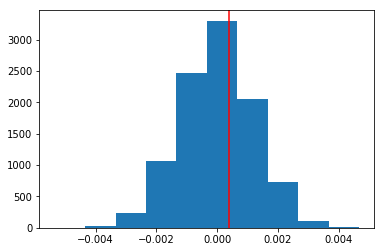

In [30]:
plt.hist(p_diffs)
plt.axvline(x=difference, color="red")

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [31]:
df_t = df2[df2["group"] == "treatment"]
df_c = df2[df2["group"] == "control"]
diffs = df_t['converted'].mean() - df_c['converted'].mean()
diffs

-0.0015782389853555567

In [32]:
p_diffs = np.array(p_diffs)
p_val = (p_diffs > diffs).mean()
p_val

0.90510000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I computed the p-value with the formula above. It is 0.909, which is much laeger than 0.05. Therefore, the result shows that the null hypothesis is true and new and old pages do not have differences.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2[df2["group"] == "control"]["converted"].sum()
convert_new = df2[df2["group"] == "treatment"]["converted"].sum()
n_old = df2[df2["landing_page"] == "old_page"].shape[0]
n_new = df2[df2["landing_page"] == "new_page"].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_test, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value=None, alternative='smaller', prop_var=False)
z_test, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value is aboout 0.905, which is still much higher than 0.05.Also, Z-score is approximately 1.31. Judjing from these values, you cannot reject the findings in parts j. ahnd k. It means that there is no evidence to reject the null hypothesis.**

<a id='regression'></a>
## Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference 
in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2["intercept"] = 1
df2[["new_page", "old_page"]] = pd.get_dummies(df2["landing_page"])
df2[["control", "ab_page"]] = pd.get_dummies(df2["group"])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,0,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,0,0,1


In [36]:
df2.drop(["new_page", "control"], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
result = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        05:58:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.190, and it is differs from the value computed in the Part II because the p-value is used to see whether a parameter equals to 0 which is null or does not equal to 0, regarded as alternative in regression. On the other hand, in Part II, the p-value was used to predict which page has more conversions.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**You need to consider other factors when using regression model. You could find other factors which would have influences on the results of hypothesis. On the other hand, there are disadvantages when cosidering other factors such as collinearity. When considering other factors, the factors would correlate with each other. In this sense, it is critical to find the the least important factors and remove them.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
country_df = pd.read_csv("countries.csv")
df3 = df2.merge(country_df, on="user_id", how="inner")
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA


In [40]:
df3["country"].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [41]:
df3[['US', 'UK', 'CA']] = pd.get_dummies(df3["country"])

In [42]:
sm.Logit(df3["converted"], df3[["intercept", "ab_page", "CA", "UK"]]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 04 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        05:58:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [43]:
df3["group_country"] = df3["group"] + '_' + df3["country"]
df3 = df3.join(pd.get_dummies(df3["group_country"]))
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,old_page,ab_page,country,US,UK,CA,group_country,control_CA,control_UK,control_US,treatment_CA,treatment_UK,treatment_US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1,treatment_US,0,0,0,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1,treatment_US,0,0,0,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0,treatment_CA,0,0,0,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0,treatment_UK,0,0,0,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0,treatment_CA,0,0,0,1,0,0


In [44]:
sm.Logit(df3["converted"], df3[["intercept", "ab_page", "CA", "UK", "treatment_CA", "treatment_UK"]]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 04 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        05:58:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page         -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA               0.0175      0.038      0.465      0.642      -0.056       0.091
UK               0.0118      0.040      0.296      0.767      -0.066       0.090
treatment_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
treatment_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
================================================================================
"""

<h2>Conclusion</h2>
<br><b>The p-values calculated above are higher than 0.05, which means difference of countires does not have critical impact on conversion rate between old and new pages.</b></br>

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0